In [361]:
import numpy as np
import matplotlib.pyplot as plt 
#from skimage import filters
import scipy
import os
import pandas as pd
from collections import Counter
from scipy import stats
import glob
from collections import Counter
import json
import re
from sklearn.cluster import MeanShift, estimate_bandwidth

from scipy import stats, signal

def annot(xmax,ymax,text,dir, ax=None):
 
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    if dir>0:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.5), **kw)
    else:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.02,ymax+.5), **kw)

def annot_max(x,y,text,dir, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()

    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    if dir>0:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.5), **kw)
    else:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.02,ymax+.5), **kw)

In [399]:


#area	0.42	cm^2 
constant=2.69E+05
nelectrons=1 #	e
Diffusion=  7.20E-06# ferrocene cm^2/s
Concentration=5.00E-06#ferrocene mol/cm^3
#speed	3.00E+00	volts/s
area=1

areaConstant = constant*(nelectrons**1.5)*(Diffusion**0.5)*Concentration
areaConstant

folder=r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\CV measurements\2022-DEC-01 1757 #1]_Biased_MPA_FunctionalizationOnChip_" 
 
allFiles = glob.glob( folder+"/**/*.csv", recursive=True)
allFiles=[os.path.dirname(os.path.dirname(x)) for x in allFiles if 'Voltammogram' in x]
len(allFiles)
 

34

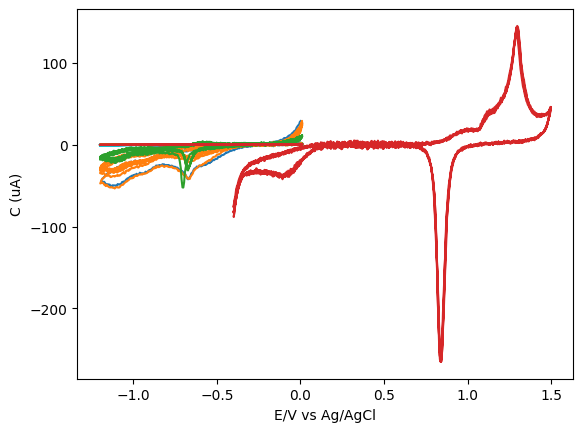

In [421]:
CVs={}
for dataDir in allFiles:
    filePot = dataDir + r"\\experiment\\results\\Measured Potential.csv"
    fileCur = dataDir + r"\\experiment\\results\\Measured Current.csv"
    pot=pd.read_csv(  filePot ) 
    cur=pd.read_csv(  fileCur ) 
    
    time=cur['Time (s)']
    pot =np.interp(cur['Time (s)'], pot['Time (s)'], pot['Potential (V)'])
 
    
    
    cur=cur['Current (A)']
    scanRate =np.zeros_like(cur)
    cycle =np.zeros_like(cur)
    totalcycle =np.zeros_like(cur)
    
    peakIDX, _ =  scipy.signal.find_peaks(-1*pot, height=0)
    peakIDX2, _ =  scipy.signal.find_peaks(pot, height=0)
    minPeaks=np.min([len(peakIDX),len(peakIDX2)])
    
    peakIDX=np.sort(np.concatenate([peakIDX2,peakIDX,[0,len(pot)-1]]))
    for i in  range(0,len(peakIDX)-1):
        scanRate[peakIDX[i]:peakIDX[i+1]]=(pot[peakIDX[i+1]]-pot[peakIDX[i]])/(time[peakIDX[i+1]]-time[peakIDX[i]])
    nCycles=0    
    startPot=pot[0]
    startDirection = scanRate[0]>0
    startIndex=time[0]
    for i in range(len(scanRate)):
        curDirection =scanRate[i]>0
        if np.abs(pot[i]-startPot)<.01 and time[i]-startIndex>5 and startDirection==curDirection:
            nCycles+=1
            startIndex=time[i]
        cycle[i]=nCycles
   
    totalcycle[:]=(nCycles)
    totalcycle[1]=minPeaks
  
    cv=pd.DataFrame({'Time':time,'V':pot ,'C':cur, 'scanrate':scanRate, 'cycle':cycle,'totalcycle':totalcycle })
    plt.plot(cv.V,cv.C*1e6,label=os.path.basename(dataDir))
    #plt.plot(cv.V)
    #plt.plot(cycle)
    CVs[os.path.basename(dataDir)]=cv

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("C (uA)") 
 
plt.show()
 

In [471]:
def CalcAreaFromOxide(CV,fig):
    nCycles=float(CV.totalcycle.iloc[0])
   
    timeStep =np.mean(np.diff(CV.Time))
    plt.plot(CV.V*1000,CV.C*1e6)
    value =   CV.C *-1e6
    height = np.max(value)/2

    peak , _ =  scipy.signal.find_peaks(value, height=height)
    peakVoltageBelow = np.mean(CV.V[peak])
    peakCurrentBelow = np.mean(CV.C[peak])
    CV2=CV.loc[ (np.abs(CV.V- peakVoltageBelow)<.25) & (CV.scanrate<0)]
    height = np.min(CV2.C)/2
    FWHM=CV2.V.loc[ np.abs(CV2.C-height)<5e-6]
    FWHM_b=np.max(FWHM)-np.min(FWHM)
   
    plt.plot(CV2.V*1000,CV2.C*1e6)

    print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep*-1 ,'C')
    print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep* -6.24150975*1e18 ,'electrons')
    print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep* -6.24150975*1e18 *1.47968E-19/2*1e4,'cm^2')
    C_B=  np.sum(CV2.C-CV2.C.iloc[0])*timeStep/nCycles
    areaBelow_m2= np.sum(CV2.C-CV2.C.iloc[0])*timeStep * -6.24150975*1e18*1.47968E-19/2/nCycles/2
    print( areaBelow_m2*1e4, 'cm^2')


    height = np.max(CV.C *1e6)*.75
    peak , _ =  scipy.signal.find_peaks(CV.C *1e6, height=height)
    
    peakVoltageAbove = np.mean(CV.V[peak])
    peakCurrentAbove = np.mean(CV.C[peak])


    CV2=CV.loc[ (np.abs(CV.V-    peakVoltageAbove)<.25) & (CV.scanrate>0)]
    height = np.max(CV2.C) /2
    FWHM=CV2.V.loc[ np.abs(CV2.C-height)<5e-6]
    FWHM_a=np.max(FWHM)-np.min(FWHM)
    
    plt.plot(CV2.V*1000,CV2.C*1e6)
    
   
    C_A=np.sum(CV2.C-CV2.C.iloc[0])*timeStep/nCycles
    areaAbove_m2= np.sum(CV2.C-CV2.C.iloc[0])*timeStep * 6.24150975*1e18*1.47968E-19/2/nCycles/2
    print( areaAbove_m2*1e4, 'cm^2')    
    
    E0=(peakVoltageBelow+peakVoltageAbove )/2.0
    C_E0=np.mean( CV.C.loc[ np.abs(CV.V-E0)<.05])
    Er=(peakVoltageBelow-E0)
    Eo=(peakVoltageAbove-E0 )
    
    voltageTexts ='E0: %.2f mV\n'%( E0*1000)
    voltageTexts +='E-:\n   %.2f mV\n   ip: %.2f uA\n   FWHM: %.2f mV\n   Q: %.2f mC\n   ~e: %.2f \n' % ((Er+E0)*1000,peakCurrentBelow*1e6,FWHM_b*1000,C_B*1000,90.6/(FWHM_b*1000) )
    voltageTexts +='E+:\n   %.2f mV\n   ip: %.2f uA\n   FWHM: %.2f mV\n   Q: %.2f mC\n   ~e: %.2f \n'%( (Eo+E0)*1000,peakCurrentAbove*1e6,FWHM_a*1000,C_A*1000,90.6/(FWHM_a*1000) )
    voltageTexts +='deltaE: %.2f mV'% (-1000*( Er-Eo))
    
    sig_peaks=np.array([E0,Er+E0,Eo+E0])*1000
    contur_min=[0,0,0]
    contur_max=np.array([C_E0,peakCurrentBelow,peakCurrentAbove])*1e6
    plt.vlines(x=sig_peaks, ymin=contur_min, ymax=contur_max,colors='r')
    
    areaStats={'peakVoltageBelow':peakVoltageBelow,
            'peakCurrentBelow':peakCurrentBelow,
            'areaBelow_m2':areaBelow_m2,
            'peakVoltageAbove':peakVoltageAbove,
            'peakCurrentAbove':peakCurrentAbove,
            'areaAbove_m2':areaAbove_m2,
            'E0':E0,
            'deltaE':np.abs(Er-E0),
            'FWHM':1
           }
    
    areaB='\nA: %.2f cm^2 Disk Radius:%.2f cm'%( area_stats['areaBelow_m2']*1e4, np.sqrt(area_stats['areaBelow_m2']*1e4/3.1415))
    areaB+='\nA: %.2f cm^2 Disk Radius:%.2f cm'%( area_stats['areaAbove_m2']*1e4, np.sqrt(area_stats['areaAbove_m2']*1e4/3.1415))
    
    
    plt.gcf().text(1, 0.5,   voltageTexts+'\n' +areaB + '\n'  , fontsize=10)
    #annot(area_stats['peakVoltageBelow']*1000,area_stats['peakCurrentBelow']*1e6,'%.2f E(mV)' % (1000*(Er+E0)),1 )
    #annot(area_stats['peakVoltageAbove']*1000,area_stats['peakCurrentAbove']*1e6,'%.2f E(mV)' % (1000*(Eo+E0)),1 )
    
    return areaStats

0.0014670126414020746 C
9156373704684302.0 electrons
6.774251521673634 cm^2
0.8467814402092042 cm^2
0.7572444819588215 cm^2


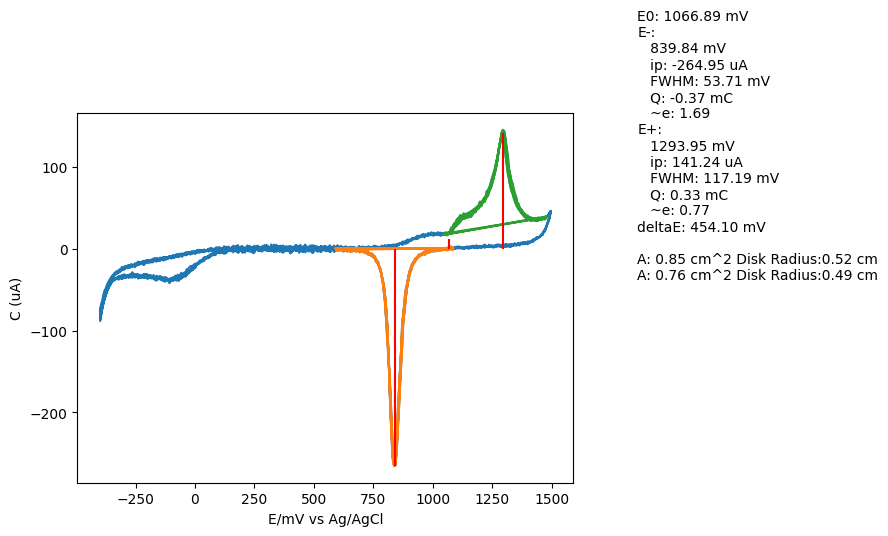

In [473]:
fig=plt.figure()

area_stats=CalcAreaFromOxide(CV,fig)
plt.title="Reductive CVs"
plt.xlabel("E/mV vs Ag/AgCl")
plt.ylabel("C (uA)") 
 
plt.show()  

CV Experiment [2022-DEC-01 1828 #9]
4.0 nCycles
0.0014670126414020746 C
9156373704684302.0 electrons
6.774251521673634 cm^2
6.774251521673634 cm^2
6.057955855670572 cm^2


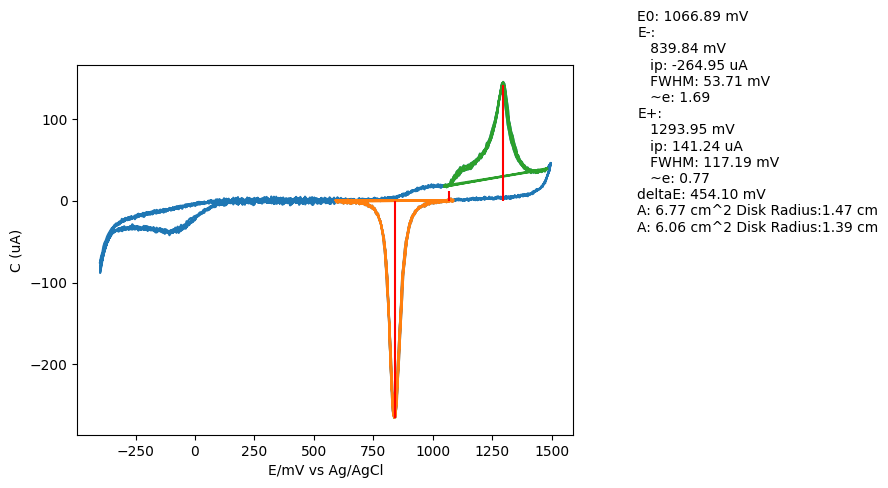

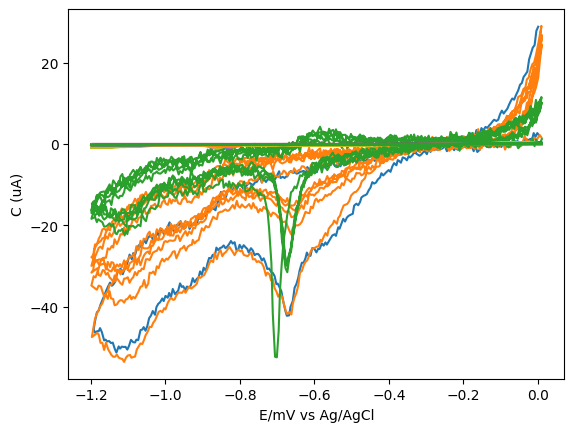

In [427]:
surfaceArea_m2=0

plt.title="Area CVs"
plt.xlabel("E/mV vs Ag/AgCl")
plt.ylabel("C (uA)")

for cv in areaCV:
    CV=areaCV[cv]
    print(cv)
    area_stats=CalcAreaFromOxide(CV,plt)
    surfaceArea_m2=np.mean([below,above])
    
    
plt.show()  

reductive={}
areaCV={}
for cv in CVs:
    potentialMax = CVs[cv].V.max()
    potentialMin = CVs[cv].V.min()
    if potentialMin<-.8 and potentialMax<1 :
        reductive[cv]=CVs[cv]
    else:
        areaCV[cv]=CVs[cv]

for cv in reductive:
    plt.plot(reductive[cv].V,reductive[cv].C*1e6,label=os.path.basename(cv))
    
plt.title="Reductive CVs"
plt.xlabel("E/mV vs Ag/AgCl")
plt.ylabel("C (uA)") 
 
plt.show()    



0.867512880660077 0.8127291099174755 1.6428222953629812
-5.6767029836454014e-05 C
-354311970202768.6 electrons
-0.2621341680348163 cm^2
-0.13106708401740816 cm^2


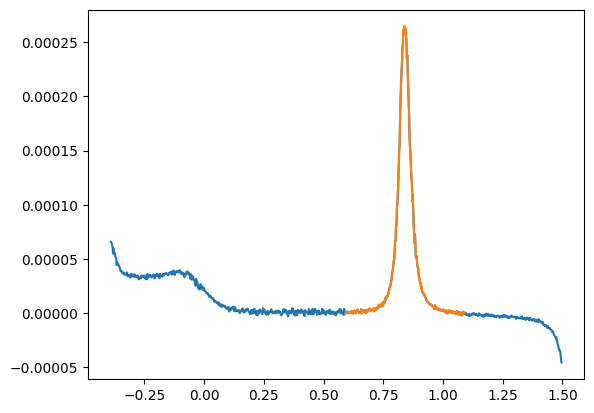

In [463]:
timeStep =np.mean(np.diff(CV.Time))
 
value =   CV.C *-1e6
height = np.max(value)/2


def CalcPeak(CV,scanDirection,width):
    CV2=CV.loc[ (CV.scanrate*scanDirection>0)]
    f = scipy.interpolate.interp1d(CV2.V, CV2.C*scanDirection)
    V=np.linspace(np.min(CV2.V),np.max(CV2.V),1000 )
    dt= np.mean(np.diff(V))/np.mean(CV2.scanrate)
     
    C=f(V)
    plt.plot(V,C)
    height = np.max(C)/2

    peak , _ =  scipy.signal.find_peaks(C, height=height)
     
    peakVoltage = np.mean(V[peak])
    peakCurrent = np.mean(V[peak])
    
    PeakV=V[ (np.abs(V- peakVoltage)<width)]
    PeakCur=C[ (np.abs(V- peakVoltage)<width)]
    plt.plot(PeakV,PeakCur)
    
    HM = np.max(PeakCur)/2
    vMax=V[(V>peakVoltage) & (C<HM)][0]
    vMin=V[(V<peakVoltage) & (C<HM)][-1]
    
    FWHM=vMax-vMin
    print(vMax,vMin,90/(FWHM*1000))

    

    Columbs=np.sum(CV2.C-CV2.C.iloc[0])*timeStep*-1/CV.totalcycle.iloc[0]
    print( Columbs ,'C')
    print(Columbs* 6.24150975*1e18 ,'electrons')
    print( Columbs* 6.24150975*1e18 *1.47968E-19/2*1e4,'cm^2')
    areaBelow_m2= Columbs * 6.24150975*1e18*1.47968E-19/2/2
    print( areaBelow_m2*1e4, 'cm^2')

CalcPeak(CV,-1,.25)

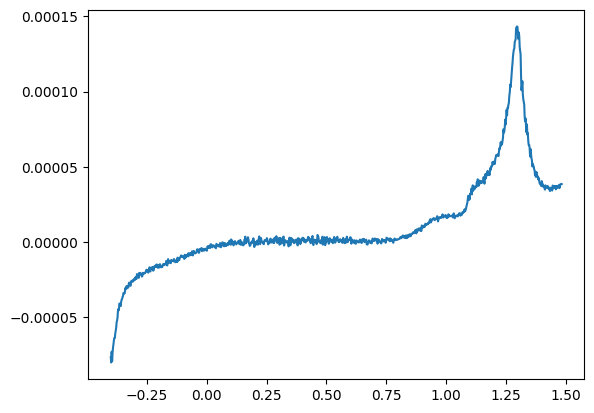

In [444]:

plt.plot(x,f(x))

def datafit(x,N,u,sig,pw,C):
    y = N*np.exp(-(np.abs(x-u)/sig)**pw/2)+C
    return y

popt,popc = scipy.optimize.curve_fit(datafit,CV2.V,CV2.C*-1,p0=[height*2,peakVoltage,.1,2,0])

plt.plot(CV2.V,CV2.C*-1)
plt.plot(CV2.V,datafit(CV2.V,popt[0],popt[1],popt[2],popt[3],popt[4]))
plt.show()  
popt,popc

In [ ]:
vFilter =['300mv_','20mvs',"_TA"]
selected=[]
for cvName in CVs:
    filtered=True
    for filt in vFilter:
        
        if not (filt in cvName):
            filtered=False
    if filtered:
        selected.append(cvName)
print(selected)        
plt.figure    (figsize=(20,10))        
for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J
    plt.plot(x1,y1,label=cvName)
    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.05]
    boring3 = boring2.loc[ cv.Potential>-.05]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

    res = stats.linregress(boring3.Potential, boring3.J)
    yMax =np.max(cvl.J)
    xMax= cvl.Potential.iloc[np.argmax(cvl.J)]
    baseline =yMax-( res.slope*xMax+res.intercept)
    #plt.plot(cvl.Potential,res.slope*cvl.Potential+res.intercept)
    text= "%.2f A/m^2 @  %.2fV"%(baseline, xMax)
    
    
    annot_max(x1,y1,text)
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()

In [ ]:
vFilter =['300mv_','100mvs',"_TA"]
selected=[]
for cvName in CVs:
    filtered=True
    for filt in vFilter:
        
        if not (filt in cvName):
            filtered=False
    if 'BIO' in cvName:
        filtered=False
    if filtered:
        selected.append(cvName)
    if cvName =='KOH_EC_300mv_100mvs':
        selected.append(cvName)
    
plt.figure    (figsize=(10,5))        
cc=0
"""Flame Annealed	None	Timeetch"""
coverage=[0.95,0,0.83,0.83]

for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J

    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.05]
    boring3 = boring2.loc[ cv.Potential>-.05]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

    res = stats.linregress(boring3.Potential, boring3.J)
    yMax =np.max(cvl.J)
    xMax= cvl.Potential.iloc[np.argmax(cvl.J)]
    baseline =yMax-( res.slope*xMax+res.intercept)
    #plt.plot(cvl.Potential,res.slope*cvl.Potential+res.intercept)
    #text= (r"%.2f $A/m^{2}$, C=%.0f%%, E=%.2fV")%(baseline,coverage[cc]*100, xMax)
    
    plt.plot(x1,y1,label=cvName)
    #annot_max(x1,y1,text)
    cc+=1
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()

In [ ]:
vFilter =['300mv_','100mvs',"_TA"]
selected=[]
for cvName in CVs:
    if cvName =='Blank_60mV':
        selected.append(cvName)
    if cvName =='Biotin pH13_60mV':
        selected.append(cvName)
    if cvName =='Biotin A_60mV':
        selected.append(cvName)        
        
plt.figure    (figsize=(10,5))        
cc=0
"""Flame Annealed	None	Timeetch"""
coverage=[0.95,0,0.83,0.83]

for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J

    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.05]
    boring3 = boring2.loc[ cv.Potential>-.05]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

    res = stats.linregress(boring3.Potential, boring3.J)
    yMax =np.max(cvl.J)
    xMax= cvl.Potential.iloc[np.argmax(cvl.J)]
    baseline =yMax-( res.slope*xMax+res.intercept)
    #plt.plot(cvl.Potential,res.slope*cvl.Potential+res.intercept)
    #text= (r"%.2f $A/m^{2}$, C=%.0f%%, E=%.2fV")%(baseline,coverage[cc]*100, xMax)
    
    plt.plot(x1,y1,label=cvName)
    #annot_max(x1,y1,text)
    cc+=1
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()

In [ ]:
def annot_max(x,y,xmax,ymax,text, ax=None):


    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.1), **kw)

#TEE_TAT_100mV_100mvs
vFilter =["TEE_TAT",'500mV']
selected=[]
for cvName in CVs:
    filtered=True
    for filt in vFilter:
        
        if not (filt in cvName):
            filtered=False
    if filtered:
        selected.append(cvName)
plt.figure    (figsize=(20,10))        
cc=0
"""Flame Annealed	None	Timeetch"""
coverage=[0.19,0.13]

for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J

    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.25]
    boring3 = boring2.loc[ cv.Potential>0.2]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

    res = stats.linregress(boring3.Potential, boring3.J)
    yMax =np.max(cvl.J)
    xMax=.45# cvl.Potential.iloc[np.argmax(cvl.J)]
    baseline =yMax-( res.slope*xMax+res.intercept)
    #plt.plot(cvl.Potential,res.slope*cvl.Potential+res.intercept)
    text= (r"%.2f $A/m^{2}$, C=%.0f%%, E=%.2fV")%(baseline,coverage[cc]*100, xMax)
    
    plt.plot(x1,y1,label=cvName)
    annot_max(x1,y1,xMax,yMax,text)
    cc+=1
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()

In [ ]:
def annot_max(x,y,text, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()

    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.5), **kw)
    
    xmax = x[np.argmin(y)]
    ymax = y.min()

    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    text= (r"E=%.2fV")%( xmax)
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.1,ymax+.5), **kw)    

vFilter =['300mv_',"TE_TA"]
selected=[]
for cvName in CVs:
    filtered=True
    for filt in vFilter:
        
        if not (filt in cvName):
            filtered=False
    if filtered:
        selected.append(cvName)
plt.figure    (figsize=(20,10))        
cc=0
"""Flame Annealed	None	Timeetch"""
coverage=[0.95,0,0.83,0.83]

for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J

    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.05]
    boring3 = boring2.loc[ cv.Potential>-.05]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

    res = stats.linregress(boring3.Potential, boring3.J)
    yMax =np.max(cvl.J)
    xMax= cvl.Potential.iloc[np.argmax(cvl.J)]
    baseline =yMax-( res.slope*xMax+res.intercept)
    #plt.plot(cvl.Potential,res.slope*cvl.Potential+res.intercept)
    text= (r"%.2f $A/m^{2}$,  E=%.2fV")%(baseline, xMax)
    
    plt.plot(x1,y1,label=cvName)
    annot_max(x1,y1,text)
    cc+=1
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()

In [ ]:
vFilter =["TE_TA",'20mvs']
selected=[]
for cvName in CVs:
    filtered=True
    for filt in vFilter:
        
        if not (filt in cvName):
            filtered=False
    if filtered:
        selected.append(cvName)
plt.figure    (figsize=(20,10))        
cc=0
"""Flame Annealed	None	Timeetch"""
coverage=[0.95,0,0.83,0.83]

for cvName in selected:
    cv=CVs[cvName]
    x1=cv.Potential
    y1=cv.J

    cvl=cv.loc[cv.Segment == 3]
    #plt.plot(cvl.Potential,cvl.J,label=cvName)

    boring2 = cvl.loc[ cv.Potential<0.05]
    boring3 = boring2.loc[ cv.Potential>-.05]

    #plt.plot(boring3.Potential,boring3.J,label=cvName)

   
    plt.plot(x1,y1,label=cvName)
    cc+=1
    
    

plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("Current (A/m^2)")        
plt.legend()